<a href="https://colab.research.google.com/github/johanjan/MOOC-HPFEM-source/blob/master/DigiMat_Pro_Fluid_2021_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### DigiMat Pro: Navier-Stokes fluid flow Direct FEM Simulation (DFS)



<p>Incompressible Navier-Stokes as model for low and high Reynolds number flow, such as blood flow and flight: <span class="math display">\begin{array}{rcll} 
R(\hat{u}) &;=&
\begin{cases}
  \partial_t u + (u\cdot \nabla) u + \nabla p - \nu \Delta u = 0\\
  \nabla \cdot u = 0
\end{cases}\\
u &;=& 0, x \in \Gamma \quad (\text{No-slip BC for low Reynolds number})\\
\hat{u} &=& (u, p), \quad r(\hat{u}, \hat{v}) = (R(\hat{u}), \hat{v}) \quad (\text{Weak residual})
\end{array}</span></p>
<dl>
<dt>Space-time cG(1)cG(1) FEM with GLS stabilization. Developed over 20+ years by Johnson, Hoffman, Jansson, etc.</dt>
<dd><p><span class="math display">\begin{aligned}
  &r(\hat{U}, \hat{v}) = (R(\hat{U}), \hat{v}) + (\delta R(\hat{U}), R(\hat{v})) = 0\\
  &\delta = h, \, \forall \hat{v} \in \hat{V}_h, \, \hat{U} \in \hat{V}_h\end{aligned}</span></p>
</dd>

### FEniCS DFS formulation to run and modify yourself

In [43]:
#@title
# Setup system environment and define utility functions and variables


from google.colab import files

!update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.6 3
!apt install -y software-properties-common python3-software-properties
!add-apt-repository -y ppa:fenics-packages/fenics
!apt-get install fenics


!wget -c http://www.csc.kth.se/~jjan/digitalmath/plot_u.py
!wget -c -O ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit.tar.gz 'https://www.paraview.org/paraview-downloads/download.php?submit=Download&version=v5.9&type=binary&os=Linux&downloadFile=ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit.tar.gz'
!tar xzvf ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit.tar.gz --skip-old-files


Streaming output truncated to the last 5000 lines.
ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/lib/python3.8/site-packages/twisted/test/test_iutils.py
tar: ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/lib/python3.8/site-packages/twisted/test/test_iutils.py: skipping existing file
ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/lib/python3.8/site-packages/twisted/test/test_lockfile.py
tar: ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/lib/python3.8/site-packages/twisted/test/test_lockfile.py: skipping existing file
ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/lib/python3.8/site-packages/twisted/test/test_log.py
tar: ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/lib/python3.8/site-packages/twisted/test/test_log.py: skipping existing file
ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/lib/python3.8/site-packages/twisted/test/test_logfile.py
tar: ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/lib/python3.8/site-packages/twisted/test/test_logfile.py: skipping existing file
P

In [44]:
%%writefile file.py

# Copyright (c) 2017-2018 Johan Jansson, Måns Andersson, Cem Degirmenci, David Kamensky, FEniCS community contributions 

import time

from dolfin import *
from mshr import *

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
import dolfin.common.plotting as fenicsplot

XMIN = 0.; XMAX = 4; YMIN = 0; YMAX = 1.; G = [XMIN, XMAX, YMIN, YMAX]; eps = 1e-5; mresolution=30 # Geometry and mesh
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])) - Circle(Point(.5, .5), .1), mresolution)

VE = VectorElement("CG", mesh.ufl_cell(), 1); QE = FiniteElement("CG", mesh.ufl_cell(), 1); h = CellDiameter(mesh); # FEM functions
WE = VE * QE; W = FunctionSpace(mesh, WE); V = FunctionSpace(mesh, VE); Q = FunctionSpace(mesh, QE) # Make a mixed space
(v, q) = TestFunctions(W); w = Function(W); (u, p) = (as_vector((w[0], w[1])), w[2]); u0 = Function(V)

uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) # Inflow velocity
om = Expression("x[0] > XMAX - eps ? 1. : 0.", XMAX=XMAX, eps=eps, element = Q.ufl_element()) # Mark regions for boundary conditions
im = Expression("x[0] < XMIN + eps ? 1. : 0.", XMIN=XMIN, eps=eps, element = Q.ufl_element())
nm = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, eps=eps, element = Q.ufl_element())

stepcounter = 0; 

from fenics import *

k = 0.1; nu = 1e-6; d = .2*h**(3./2.) # Timestep, viscosity and stabilization parameters
t, T = 0., 2.; gamma = 10*1./h # Time interval and penalty parameter

theta = 0.5 # 0.5 - Midpoint rule, 1.0 - Implicit Euler, 0.0 - Explicit Euler
while t < T: # Time-stepping loop
    um = theta*u + (1.0-theta)*u0 # Weak residual of stabilized FEM for Navier-Stokes eq.
    r = ((inner((u - u0)/k + grad(p) + grad(um)*um, v) + nu*inner(grad(um), grad(v)) + div(um)*q)*dx +
        gamma*(om*p*q + im*inner(u - uin, v) + nm*inner(u, v))*ds + # Weak boundary conditions
        d*(inner(grad(p) + grad(um)*um, grad(q) + grad(um)*v) + inner(div(um), div(v)))*dx) # Stabilization
    solve(r==0, w)  # Solve the Navier-Stokes PDE (one timestep)
    #plot_compact(u, t, stepcounter, Q) # Plot all quantities (see implementation above)
    t += k; stepcounter += 1; u0 = project(u, V); # Shift to next timestep

file = File("u.pvd")
uEuclidnorm = project(sqrt(inner(u, u)), Q);
uEuclidnorm.rename("Velocity", "")
file << uEuclidnorm


Overwriting file.py


In [45]:
!mpirun --allow-run-as-root -np 4 python3 file.py


!zip u.zip u*.pvd u*vtu


Process 0: No Jacobian form specified for nonlinear variational problem.
Process 0: Differentiating residual form F to obtain Jacobian J = F'.
Process 2: No Jacobian form specified for nonlinear variational problem.
Process 3: No Jacobian form specified for nonlinear variational problem.
Process 3: Differentiating residual form F to obtain Jacobian J = F'.
Process 2: Differentiating residual form F to obtain Jacobian J = F'.
Process 1: No Jacobian form specified for nonlinear variational problem.
Process 1: Differentiating residual form F to obtain Jacobian J = F'.
Process 3: Solving nonlinear variational problem.
Process 0: Solving nonlinear variational problem.
Process 2: Solving nonlinear variational problem.
Process 1: Solving nonlinear variational problem.
  Process 0: Newton iteration 0: r (abs) = 1.958e+01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Process 0: Newton iteration 1: r (abs) = 2.094e-02 (tol = 1.000e-10) r (rel) = 1.069e-03 (tol = 1.000e-09)
  Process 

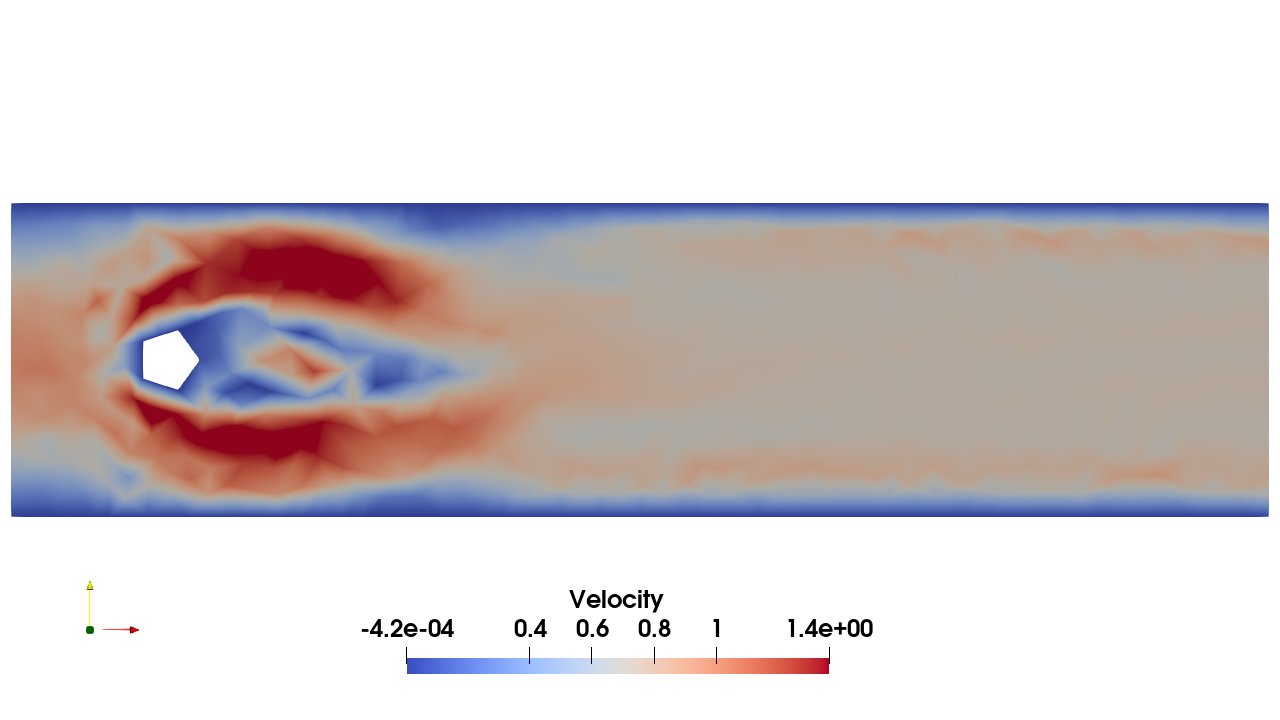

In [46]:
!/content/ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/bin/pvpython plot_u.py


from IPython.display import Image
Image('plot_u.png')

